In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This project uses the data from kaggle: https://www.kaggle.com/sid321axn/amazon-alexa-reviews

# 1. Dataset

In [2]:
data = pd.read_csv('amazon_alexa.tsv', delimiter='\t', quoting=3)
print('data shape: {}'.format(data.shape))
data.head(3)

data shape: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
#Have a look at a review.
data['verified_reviews'].iloc[100]

'"Great fun getting to know all the functions of this product.  WOW -- family fun and homework help.  Talking with other grandchildren,who also have an Echo, is a HUGE bonus.  Can\'t wait to learn more and more and more"'

#### Feedback & rating

In [5]:
data.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

There are five different rankings from 1 to 5. Most people have scored 5 which means they are satisfied with the product. The lower the score is, the costumers are less satisfied with the product.

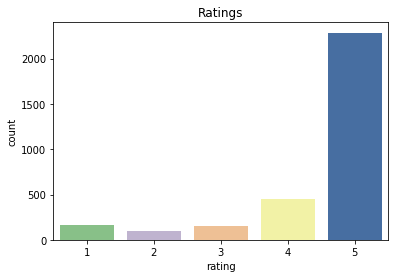

In [6]:
import seaborn as sns
sns.countplot(data['rating'], palette='Accent')
plt.title('Ratings')
plt.show()

# 2. Text preprocessing

#### remove punctuations and other speacial symbols

In [7]:
#define a function to transform the verified_reviews into standard words.
from nltk.corpus import stopwords
import re
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer

def trans_review(reviews, remove_stops=True, token='Tweet'):
    tokenizer = TweetTokenizer() if token == 'Tweet' else TreebankWordTokenizer()
    stops = set(stopwords.words('english'))#obtain set(stopwords) to save time.
        
    token_sents = []
    for sent in reviews:
        tokens = tokenizer.tokenize(sent)
        tokens = [re.sub('[^a-zA-Z]', ' ', _) for _ in tokens]#keep only the letters.
        tokens = [re.sub('\s+', ' ', _) for _ in tokens]
        tokens = [_.lower() for _ in tokens if _ != ' ']#transform into lower cases.
        if remove_stops:
            tokens = [w for w in tokens if w not in stops]#remove stopwords.
        token_sents.append(tokens)

    return token_sents

In [8]:
dt_ex = data[data['feedback']==0].iloc[2]

print(dt_ex['verified_reviews'])
print('='*60)
print(trans_review([dt_ex['verified_reviews']]))

Not much features.
[['much', 'features']]


#### Deal with the negation words 

We've found that it removes the word 'not' which is very important for analysing the sentiment. Clearly 'good' and 'not very good' indicate opposite sentiments. 

So before cleaning the words, we firstly find the positions of the negation words (not, isn't, didn't, etc.)  and we add a tag NOT to every word between a negation word and its nearest punctuation, i.e. we change 'didn't like it' => 'didn't likenot itnot' => 'likenot itnot'. We call the latter the standard negation format.

In [9]:
#generate a list of possible negation words.
neg_words = {"don't", "never",  "nothing", "nowhere", "noone", "none", "not",
              "hasn't", "hadn't", "can't", "couldn't", "shouldn't", "won't",
              "wouldn't", "don't", "doesn't", "didn't", "isn't", "aren't", "ain't"}

def neg_trans(sentence):
    sentence = sentence.lower()
    punct = re.findall(r'[.:;!?]', sentence)

    for neg in neg_words:
        #find the position of negation words and transform the sentence to standard negation format.
        pos_word = sentence.find(neg)
        if pos_word == -1:
            continue
            
        #find the position of the nearest punctuations.
        if punct:
            pos_punct = sentence.find(punct[0])
            pos_punct = pos_punct if pos_punct else  -1
        else:
            pos_punct = -1

        s1 =  re.sub(r'\b([A-Za-z\']+)\b', r'\1NOT',#The part between the neg word and the nearest puntuation.
                               sentence[(pos_word+len(neg)+1):pos_punct])
        s2 = sentence[pos_punct:]#The part after the nearest punctuation.
        sentence = s1 + s2
    return sentence

In [10]:
print(dt_ex['verified_reviews'])
print('='*60)
print(neg_trans(dt_ex['verified_reviews']))

Not much features.
muchNOT featuresNOT.


In [11]:
#apply the text preproccessing function to the whole dataframe.
data['clean_review'] = data['verified_reviews'].apply(lambda x: neg_trans(x))
data['clean_review'] = trans_review(data['clean_review'], remove_stops=True)
print(data[data['feedback']==0]['clean_review'].iloc[2])
data.head(3)

['muchnot', 'featuresnot']


,rating,date,variation,verified_reviews,feedback,clean_review
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,"[love, echo]"
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,[loved]
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,"[sometimes, playing, game, answer, question, c..."


#### Extract the word stems

In [13]:
from nltk.stem.snowball import EnglishStemmer

stemmer = EnglishStemmer()
data['stem_words'] = data['clean_review'].apply(lambda x: [stemmer.stem(word) \
                                                           for word in x])
dt_ex = data[data['feedback']==0].iloc[2]
print('verified review ex: ', dt_ex['verified_reviews'])
print('='*60)
print('clean_review ex: ', dt_ex['clean_review'])
print('='*60)
print('stem_words ex: ', dt_ex['stem_words'])
data.tail(3)

verified review ex:  Not much features.
clean_review ex:  ['muchnot', 'featuresnot']
stem_words ex:  ['muchnot', 'featuresnot']


,rating,date,variation,verified_reviews,feedback,clean_review,stem_words
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,"[love, things, running, entire, home, tv, ligh...","[love, thing, run, entir, home, tv, light, the..."
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,"[mindnot, thenot, audionot, qualitynot, butnot...","[mindnot, thenot, audionot, qualitynot, butnot..."
3149,4,29-Jul-18,Black Dot,Good,1,[good],[good]


#### Visuliaze the frequency of words in reviews

In [14]:
#Frequency of words.
from collections import Counter
import operator

stem_words_list = []
for word in data['stem_words']:
    stem_words_list.extend(word)
count_words = Counter(stem_words_list)

#Sort count_words by value.
count_words = sorted(count_words.items(),\
                     key=operator.itemgetter(1), reverse=True)

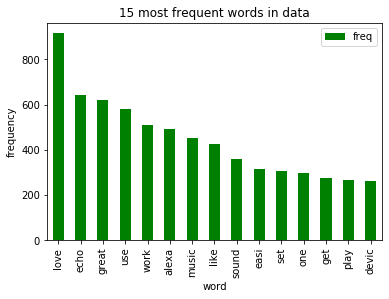

In [15]:
#Plot the most frequent words.
n_plot = 15
count_words_plot = count_words[:n_plot]
df_count_plot = pd.DataFrame(count_words_plot, columns=['word', 'freq'])
df_count_plot.plot(x='word', y='freq', kind='bar', color='g')
plt.xlabel('word')
plt.ylabel('frequency')
plt.title('%d most frequent words in data'%n_plot)
plt.show()

**note** we can see that the most frequent words(except the stopwords: the, we...) are 'love', 'echo', 'great'... which are relatively positive.

In [16]:
#Plot the word frequency of each rating.
data['count_stems'] = data['stem_words'].apply(lambda x: Counter(x))

df_count_group = data.groupby(['rating']).count_stems.sum()

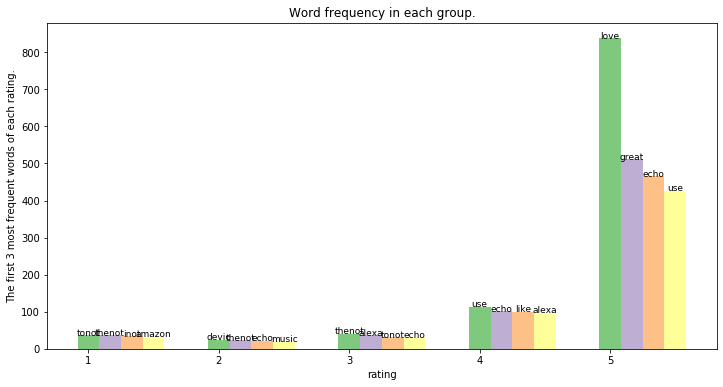

In [17]:
#Plot the first 4 most frequent words of each rating.
max_word_plot = 4
barwidth = 1/(max_word_plot+2)

plt.figure(figsize=(12, 6))
colors = plt.get_cmap('Accent')

for rating, d in enumerate(df_count_group):
    d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    for i, (word, freq) in enumerate(d):
        if i >= max_word_plot:
            break
        plt.bar(rating+1, freq, width=barwidth, color=colors(i))
        plt.text(rating+1, freq, word, fontsize=9, horizontalalignment='center')
        rating += barwidth
        
plt.xticks(df_count_group.keys())
plt.title('Word frequency in each group.')
plt.xlabel('rating')
plt.ylabel('The first 3 most frequent words of each rating.')
plt.show()

# 3. Classification using scikit-learn

## 3.1 RandomForest

In this part, we focus on the coluns 'feedback' and use the RandomForestClassifier to try to construct a sentiment classifer.

#### Modelling

In [18]:
len_stems = data['stem_words'].apply(lambda x: len(x))
print(len(len_stems[len_stems==0]))

86


In [19]:
#Drop the empty reviews
data_reviews = data.copy()
data_reviews = data_reviews.drop(len_stems[len_stems==0].index)
print('After droping empty reviews:\ndata length: {} => {}'.format(\
                                                len(data), len(data_reviews)))

After droping empty reviews:
data length: 3150 => 3064


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X = [' '.join(x) for x in data_reviews['stem_words']]
#split data into training/test dataset.
random_state = 2020
X_train, X_test, y_train, y_test = train_test_split(X, data_reviews['feedback'], \
                                            test_size=.2, random_state=random_state)
print('Traing dataset length: {}, test dataset length: {}'.format(\
                                                len(X_train), len(X_test)))

Traing dataset length: 2451, test dataset length: 613


In [21]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer(min_df=2)
word_vect_train = vectorizer.fit_transform(X_train)
print(word_vect_train.shape)#n_samples * n_features.

rf = RandomForestClassifier(n_estimators=100).fit(word_vect_train, y_train)

(2451, 1936)


#### Evaluation

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

print("Evaluation on test dataset:")
word_vect_test = vectorizer.transform(X_test)
y_pred = rf.predict(word_vect_test)
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('='*60)
print('Classification Report: ')
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

Evaluation on test dataset:
Confusion Matrix: 
[[ 18  31]
 [ 10 554]]
Classification Report: 


,precision,recall,f1-score,support
0,0.642857,0.367347,0.467532,49.000000
1,0.947009,0.982270,0.964317,564.000000
accuracy,0.933116,0.933116,0.933116,0.933116
macro avg,0.794933,0.674808,0.715925,613.000000
weighted avg,0.922696,0.933116,0.924606,613.000000


**note** We've found that the confusion matrix has a relatively large FP, i.e. it tends to predict a negative sentiment sample as a positive sample. 

#### GridSearch

Here we want to find the optimal hyperparameters of CountVectorizer and RandomForest to improve the performance.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vectorizer', CountVectorizer()),
                    ('rf', RandomForestClassifier())])
params = {'vectorizer__max_features': [100, 500, 1000, 2000, None],
          'vectorizer__min_df': range(1, 5),
         'rf__n_estimators': [50, 100, 200]}
cv = 3

search = GridSearchCV(pipeline, params, cv=cv).fit(X_train, y_train.array)
search.best_params_

{'rf__n_estimators': 100,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3}

In [24]:
#Now we see if the performance has been improved!
clf_rf_optimal = search.best_estimator_
y_pred = clf_rf_optimal.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.678571,0.387755,0.493506,49.000000
1,0.948718,0.984043,0.966057,564.000000
accuracy,0.936378,0.936378,0.936378,0.936378
macro avg,0.813645,0.685899,0.729782,613.000000
weighted avg,0.927124,0.936378,0.928284,613.000000


## 3.2 Naive Bayes Classifier

In [25]:
from sklearn.naive_bayes import MultinomialNB
piepline = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [26]:
params = {'cv__min_df': range(1, 5),
    'nb__alpha': [1e-4, 1e-3, 1e-2, 1e-1]}
search = GridSearchCV(piepline, params)
search.fit(X_train, y_train.array)
search.best_params_

{'cv__min_df': 1, 'nb__alpha': 0.0001}

In [27]:
clf_nb_optimal = search.best_estimator_
y_pred_nb = clf_nb_optimal.predict(X_test)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_nb))
print('='*60)
print('Classification Report of Naive Bayes:')
display(pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).T)

Confusion Matrix: 
[[ 17  32]
 [ 14 550]]
Classification Report of Naive Bayes:


,precision,recall,f1-score,support
0,0.548387,0.346939,0.425000,49.000000
1,0.945017,0.975177,0.959860,564.000000
accuracy,0.924959,0.924959,0.924959,0.924959
macro avg,0.746702,0.661058,0.692430,613.000000
weighted avg,0.913313,0.924959,0.917106,613.000000


In [28]:
from sklearn.metrics import roc_auc_score
print('The AUC score of NB and RandomForest are %.4f and %.4f respectively.'%(\
                    roc_auc_score(y_pred_nb, y_test), roc_auc_score(y_pred, y_test)))

The AUC score of NB and RandomForest are 0.7467 and 0.8136 respectively.


## 3.3 SVM

Construct a function for Grid Search

In [29]:
from sklearn.svm import SVC
piepline = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC())
])
params = {'cv__min_df': range(1, 5),
          'svc__kernel': ['linear', 'rbf'],
    'svc__C': [1, 10, 100, 1000]}
search = GridSearchCV(piepline, params)
search.fit(X_train, y_train.array)
search.best_params_

{'cv__min_df': 3, 'svc__C': 10, 'svc__kernel': 'rbf'}

In [30]:
clf_svc_optimal = search.best_estimator_
y_pred_svc = clf_svc_optimal.predict(X_test)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_svc))
print('='*60)

print('Classification Report of SVC:')
display(pd.DataFrame(classification_report(y_test, y_pred_svc, output_dict=True)).T)

Confusion Matrix: 
[[ 15  34]
 [  2 562]]
Classification Report of SVC:


,precision,recall,f1-score,support
0,0.882353,0.306122,0.454545,49.000000
1,0.942953,0.996454,0.968966,564.000000
accuracy,0.941272,0.941272,0.941272,0.941272
macro avg,0.912653,0.651288,0.711755,613.000000
weighted avg,0.938109,0.941272,0.927845,613.000000


Now we set the parameter class_weight='balanced' since our dataset is very imbalanced.

In [31]:
#Balance the weights
piepline = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC(class_weight='balanced'))
])
params = {'cv__min_df': range(1, 5),
          'svc__kernel': ['linear', 'balanced'],
    'svc__C': [1, 10, 100, 1000]}
search = GridSearchCV(piepline, params)
search.fit(X_train, y_train.array)
search.best_params_

{'cv__min_df': 1, 'svc__C': 1, 'svc__kernel': 'linear'}

In [34]:
clf_svc_imb_optimal = search.best_estimator_
y_pred_svc_imb = clf_svc_imb_optimal.predict(X_test)
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_svc_imb))
print('='*60)

print('Classification Report of SVC with balaned weight:')
display(pd.DataFrame(classification_report(y_test, y_pred_svc_imb, output_dict=True)).T)

print('The AUC score of SVC is %.4f'%(roc_auc_score(y_test, y_pred_svc_imb)))

Confusion Matrix: 
[[ 21  28]
 [ 18 546]]
Classification Report of SVC with balaned weight:


,precision,recall,f1-score,support
0,0.538462,0.428571,0.477273,49.000000
1,0.951220,0.968085,0.959578,564.000000
accuracy,0.924959,0.924959,0.924959,0.924959
macro avg,0.744841,0.698328,0.718425,613.000000
weighted avg,0.918226,0.924959,0.921025,613.000000


The AUC score of SVC is 0.6983


**note** Naive Bayes has a small recall so that it will tend to predict the negative labels as positive. Among these three methods, SVC(balanced) have a superior performance.
 
Before coming to a conclusion, we'll try using the neural network.

# 4. pytorch

In this part, we'll build a neural network using the module pytorch to predict the labels of each review. We'll follow the next steps:
- Build a class of neural network.
- Load and tokenizer the corpus.
- Map tokens(resp. sentiments) with index_tokens(resp. index_sentim) and symetrically.
- Train the model using optimizer as torch.optim.SGD and loss function as NLLLoss.
- Evaluate our model.

In [33]:
import torch
from torch import nn, optim, tensor

In [35]:
X_train = [x.split() for x in X_train]
y_train = y_train.array

#### Build a class SequenceLabeller

In [36]:
from torch.nn.functional import log_softmax

class SequenceLabeller(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, \
                 num_classes, sequence_model='LSTM'):
        """
            embedding_dim: number of embeddings.
            hidden_dim: number of hidden nodes.
            vocab_size: number of unique words.
            num_classes: number of unique labels(2: positive/negative).
            sequence_model: model
        """
        super(SequenceLabeller, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        if sequence_model == "LSTM":
            #Use the LSTM model by default.
            self.seq = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        else:
            raise(Exception('Sequence Model {} not supported'.format(sequence_model)))
            
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)
        #A linear layer.
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        seq_output, (h_n, c_n) = self.seq(embeds)
        tag_space = self.hidden2tag(seq_output)
        tag_scores = log_softmax(tag_space, dim=2)
        return tag_scores 

#### Map each word and label with the correponding index

In [37]:
def map_idx(seq, idx):
    #map a sequence to a tensor object of index
    idx_list = [idx[w] if w in idx else len(idx) for w in seq]
    idx_tensor = tensor(idx_list, dtype=torch.long).unsqueeze(0)
    return idx_tensor

In [38]:
word_idx, sentiment_idx = {}, {}
for text, sentiment in zip(X_train, y_train):
    sentiment_idx.setdefault(sentiment, len(sentiment_idx))
    for word in text:
        word_idx.setdefault(word, len(word_idx))
        
print(sentiment_idx)

{1: 0, 0: 1}


#### Train model

In [46]:
from torch.nn.functional import one_hot, log_softmax
nll = nn.NLLLoss()
model = SequenceLabeller(50, 100, len(word_idx)+1, len(sentiment_idx))
optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 50
for epoch in range(n_epochs): 
    loss_mean_ep = 0
    n_sample = 0
    for text, sentiment in zip(X_train, y_train):
        if len(text) <= 1:#if len(text) <= 2
            continue
            
        model.zero_grad()
        text_map = map_idx(text, word_idx)        
        sentiment_map = map_idx([sentiment], sentiment_idx)
        one_hot_targets = one_hot(sentiment_map.squeeze(0), \
                                    num_classes=len(sentiment_idx))
        scores = model(text_map)
        loss = nll(scores, one_hot_targets)
        loss_mean_ep += loss
        n_sample += 1

        # Backpropagate the loss and perform an optimisation step
        loss.backward()
        optimizer.step()

    print("Epoch {} loss {:0.4f} ".format(epoch+1, loss/n_sample))

Epoch 1 loss 0.0002 
Epoch 2 loss 0.0002 
Epoch 3 loss 0.0001 
Epoch 4 loss 0.0000 
Epoch 5 loss 0.0000 
Epoch 6 loss 0.0000 
Epoch 7 loss 0.0000 
Epoch 8 loss 0.0000 
Epoch 9 loss 0.0000 
Epoch 10 loss 0.0000 
Epoch 11 loss 0.0000 
Epoch 12 loss 0.0000 
Epoch 13 loss 0.0000 
Epoch 14 loss 0.0000 
Epoch 15 loss 0.0000 
Epoch 16 loss 0.0000 
Epoch 17 loss 0.0000 
Epoch 18 loss 0.0000 
Epoch 19 loss 0.0000 
Epoch 20 loss 0.0000 
Epoch 21 loss 0.0000 
Epoch 22 loss 0.0000 
Epoch 23 loss 0.0000 
Epoch 24 loss 0.0000 
Epoch 25 loss 0.0000 
Epoch 26 loss 0.0000 
Epoch 27 loss 0.0000 
Epoch 28 loss 0.0000 
Epoch 29 loss 0.0000 
Epoch 30 loss 0.0000 
Epoch 31 loss 0.0000 
Epoch 32 loss 0.0000 
Epoch 33 loss 0.0000 
Epoch 34 loss 0.0000 
Epoch 35 loss 0.0000 
Epoch 36 loss 0.0000 
Epoch 37 loss 0.0000 
Epoch 38 loss 0.0000 
Epoch 39 loss 0.0000 
Epoch 40 loss 0.0000 
Epoch 41 loss 0.0000 
Epoch 42 loss 0.0000 
Epoch 43 loss 0.0000 
Epoch 44 loss 0.0000 
Epoch 45 loss 0.0000 
Epoch 46 loss 0.000

**note** We first filter the text by limiting the text with length >= 2, which leads to a bad recall . The reason is that the text number for the negative reviews is generally smaller than that of positive reviews. Since the proportion of negative reviews is originally small(about 200), after filtering, the model will labelize almost all the reviews as positive. 

#### Evaluation

In [40]:
def clf_auc_report(corpus, sentiments, return_pred=True):
    #Calculate the AUC score and print the classification report.
    #If return_pred = True then return the predicted score.
    pred = []
    test = []
    with torch.no_grad():
        for text, sentiment in zip(corpus, sentiments):
            text_map = map_idx(text, word_idx)
            score = model(text_map)
            pred.append(torch.mean(torch.exp(\
                                    score.squeeze(0)[:, 1])).item())
            test.append(sentiment)#map_idx([sentiment], sentiment_idx))

            
    print('AUC score: %.4f'%(roc_auc_score(test, pred)))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(test, np.array(pred)<.5)))
    display(pd.DataFrame(classification_report(test, np.array(pred)<.5, \
                                        output_dict=True)).T)
    
    if return_pred:
        return pred

In [47]:
y_pred_torch_test = clf_auc_report(X_test, y_test.array)

AUC score: 0.6030
Confusion Matrix: 
[[  0  49]
 [  0 564]]


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,49.000000
1,0.920065,1.000000,0.958369,564.000000
accuracy,0.920065,0.920065,0.920065,0.920065
macro avg,0.460033,0.500000,0.479184,613.000000
weighted avg,0.846520,0.920065,0.881762,613.000000


# 5. Classification using ratings

In this section, we'll classify the reviews using the variable 'rating' instead of 'feedback'. Then predict the feedback using the results

In [37]:
print(set(data[data['feedback']==0]['rating']))
print(set(data[data['feedback']==1]['rating']))

{1, 2}
{3, 4, 5}


We could see that the clients who left a negative feedback as $0$ all left ratings as either $0$ or $1$, and who left a positive feedback left ratings as $3, 4, 5$. So we could depart from this point and try to classify the reviews using ratings. 

In [38]:
#Reset y as ratings
X_train, X_test, y_train, y_test = train_test_split(X, data_reviews['rating'], \
                                            test_size=.2, random_state=random_state)
print('Traing dataset length: {}, test dataset length: {}'.format(\
                                                len(X_train), len(X_test)))

Traing dataset length: 2451, test dataset length: 613


**SVC**

In [39]:
#We compare the SVC and RandomForest since they perform better previously.
piepline = Pipeline([
    ('cv', CountVectorizer()),
    ('svc', SVC(class_weight='balanced'))
])
params = {'cv__min_df': range(1, 5),
          'svc__kernel': ['linear', 'balanced'],
    'svc__C': [1, 10, 100, 1000]}
search = GridSearchCV(piepline, params)
search.fit(X_train, y_train.array)
search.best_params_

{'cv__min_df': 1, 'svc__C': 1, 'svc__kernel': 'linear'}

In [41]:
clf_svc_imb_rating_optimal = search.best_estimator_
rating_pred_svc_imb_rating = clf_svc_imb_rating_optimal.predict(X_test)
y_pred_svc_imb_rating = np.zeros_like(rating_pred_svc_imb_rating)
y_pred_svc_imb_rating[rating_pred_svc_imb_rating>2] = 1
y_test_fb = data.iloc[y_test.index]['feedback'].array

print("Confusion Matrix: ")
print(confusion_matrix(y_test_fb, y_pred_svc_imb_rating))
print('='*60)

print('Classification Report of SVC with balaned weight(reviews vs ratings):')
display(pd.DataFrame(classification_report(y_test_fb, y_pred_svc_imb_rating, output_dict=True)).T)

Confusion Matrix: 
[[ 22  27]
 [ 18 546]]
Classification Report of SVC with balaned weight(reviews vs ratings):


,precision,recall,f1-score,support
0,0.550000,0.448980,0.494382,49.000000
1,0.952880,0.968085,0.960422,564.000000
accuracy,0.926591,0.926591,0.926591,0.926591
macro avg,0.751440,0.708532,0.727402,613.000000
weighted avg,0.920676,0.926591,0.923169,613.000000


**Random Forest**

In [43]:
pipeline = Pipeline([('vectorizer', CountVectorizer()),
                    ('rf', RandomForestClassifier())])
params = {'vectorizer__max_features': [100, 500, 1000, 2000, None],
          'vectorizer__min_df': range(1, 5),
         'rf__n_estimators': [50, 100, 200]}

#search = GridSearchCV(pipeline, params, cv=cv).fit(X_train, y_train.array)
clf_rf_rating_optimal = search.best_estimator_
rating_pred_rf_rating = clf_rf_rating_optimal.predict(X_test)
y_pred_rf_rating = np.zeros_like(rating_pred_rf_rating)
y_pred_rf_rating[rating_pred_rf_rating>2] = 1

print("Confusion Matrix: ")
print(confusion_matrix(y_test_fb, y_pred_rf_rating))
print('='*60)

print('Classification Report of SVC with balaned weight(reviews vs ratings):')
display(pd.DataFrame(classification_report(y_test_fb, y_pred_rf_rating, output_dict=True)).T)

Confusion Matrix: 
[[ 18  31]
 [  7 557]]
Classification Report of SVC with balaned weight(reviews vs ratings):


,precision,recall,f1-score,support
0,0.720000,0.367347,0.486486,49.00000
1,0.947279,0.987589,0.967014,564.00000
accuracy,0.938010,0.938010,0.938010,0.93801
macro avg,0.833639,0.677468,0.726750,613.00000
weighted avg,0.929111,0.938010,0.928603,613.00000


This method has a better performance than any above algo discussed before.

# 6. Conclusion

We've used four methods: RandomForest, NaiveBayes, SVC and Neural Network. We've found when we run classify the reviews using either 'feedback' or multi-label variable 'rating',  SVC(class_weight='balanced') gives a better performance

# 7. Future Work

In the future, we could also concentrate the imbalanced dataset problem. Since the number of negative feedbacks is much smaller than the number of positive feedbacks, we could do some preprocessing work like ReSampler or use the imbalanced ensemble algorithm. We could also change the score into the imbalanced score to give us a more accurate criteria.

Furthermore, we could use an ensemble method which could combine some classification algos together. 